In [30]:
import pandas as pd
df_ = pd.read_excel('Dataset (2).xlsx')

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def process_cat_dataset(df_):
    """
    Process the cat dataset according to specifications:
    - Remove specified columns
    - Remove instances where breed is unknown/other
    - Handle 'Unknown' values in NaturalAreasAbundance
    """
    # Make a copy to avoid modifying the original dataframe
    df_processed = df_.copy()
    
    # Remove Gender column
    df_processed = df_processed.drop(['Gender'], axis=1)
    
    # Remove instances where breed (Race) is unknown or other
    df_processed = df_processed[~df_processed['Race'].str.lower().isin(['unknown', 'other'])]
    
    # Handle 'Unknown' values in NaturalAreasAbundance
    # First, convert numeric values to float
    mask = df_processed['NaturalAreasAbundance'] != 'Unknown'
    df_processed.loc[mask, 'NaturalAreasAbundance'] = pd.to_numeric(
        df_processed.loc[mask, 'NaturalAreasAbundance'], 
        errors='coerce'
    )
    
    # Calculate median of numeric values
    median_value = df_processed.loc[mask, 'NaturalAreasAbundance'].median()
    
    # Replace 'Unknown' with median, explicitly specifying float dtype
    df_processed['NaturalAreasAbundance'] = df_processed['NaturalAreasAbundance'].astype(object).replace(
        'Unknown', 
        float(median_value)
    ).astype(float)
    
    return df_processed

# Example usage:
# Assuming your dataframe is called 'df_'
df_ = process_cat_dataset(df_)

# To see the results:
print(df_.info())
print("\nFirst few rows of processed dataframe:")
print(df_.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2928 entries, 0 to 3142
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    2928 non-null   object 
 1   Race                   2928 non-null   object 
 2   CatsInHouse            2928 non-null   int64  
 3   HousingType            2928 non-null   object 
 4   Zone                   2928 non-null   object 
 5   TimeOutside            2928 non-null   int64  
 6   TimeWithOwner          2928 non-null   int64  
 7   Shy                    2928 non-null   int64  
 8   Calm                   2928 non-null   int64  
 9   Skittish               2928 non-null   int64  
 10  Intelligent            2928 non-null   int64  
 11  Vigilant               2928 non-null   int64  
 12  Tenacious              2928 non-null   int64  
 13  Affectionate           2928 non-null   int64  
 14  Friendly               2928 non-null   int64  
 15  Loner    

C:\Users\mihai\AppData\Local\Temp\ipykernel_21064\3879293380.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['NaturalAreasAbundance'] = df_processed['NaturalAreasAbundance'].astype(object).replace(


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from datetime import datetime

def perform_stratified_split_and_save(df, output_dir='data_output', test_size=0.1, random_state=42):
    """
    Performs stratified sampling based on the Race column and saves the results to CSV files.
    
    Parameters:
    df: pandas DataFrame
    output_dir: str, directory where CSV files will be saved
    test_size: float, proportion of the dataset to include in the test split
    random_state: int, random state for reproducibility
    
    Returns:
    train_df: Training DataFrame
    test_df: Test DataFrame
    """
    
    # First, let's look at the distribution of races before splitting
    original_distribution = df['Race'].value_counts(normalize=True)
    
    # Perform stratified split
    train_idx, test_idx = train_test_split(
        np.arange(len(df)),
        test_size=test_size,
        random_state=random_state,
        stratify=df['Race']
    )
    
    # Create train and test datasets
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()
    
    # Calculate distributions after splitting
    train_distribution = train_df['Race'].value_counts(normalize=True)
    test_distribution = test_df['Race'].value_counts(normalize=True)
    
    # Print the distributions to verify stratification
    print("\nOriginal Distribution:")
    print(original_distribution)
    print("\nTraining Set Distribution:")
    print(train_distribution)
    print("\nTest Set Distribution:")
    print(test_distribution)
    
    # Print the sizes of the splits
    print(f"\nTotal samples: {len(df)}")
    print(f"Training samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
    
    return train_df, test_df

# Example usage:
train_df, test_df = perform_stratified_split_and_save(df_)


Original Distribution:
Race
European            0.349044
NoBreed             0.164959
Bengal              0.081626
Ragdoll             0.074112
MaineCoon           0.067623
Birman              0.065574
Persian             0.065574
BritishShorthair    0.056694
Sphynx              0.025956
Siamese             0.019809
Chartreux           0.010587
TurkishAngora       0.009563
Savannah            0.008880
Name: proportion, dtype: float64

Training Set Distribution:
Race
European            0.349146
NoBreed             0.165085
Bengal              0.081594
Ragdoll             0.074004
MaineCoon           0.067552
Birman              0.065655
Persian             0.065655
BritishShorthair    0.056546
Sphynx              0.025806
Siamese             0.019734
Chartreux           0.010626
TurkishAngora       0.009488
Savannah            0.009108
Name: proportion, dtype: float64

Test Set Distribution:
Race
European            0.348123
NoBreed             0.163823
Bengal              0.081911
Ra

In [33]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

def balance_races(df, min_samples=50, max_samples=55):
    """
    Balance races in the dataset using SMOTE and undersampling to ensure each race has
    between min_samples and max_samples instances.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe
    min_samples (int): Minimum number of samples required for each race
    max_samples (int): Maximum number of samples allowed for each race
    
    Returns:
    pandas.DataFrame: Balanced dataframe
    dict: Distribution of races before and after balancing
    """
    # Store original distribution
    original_distribution = df['Race'].value_counts().to_dict()
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Create label encoders for each categorical column
    encoders = {}
    df_encoded = df.copy()
    
    for col in categorical_cols:
        encoders[col] = LabelEncoder()
        df_encoded[col] = encoders[col].fit_transform(df[col])
    
    # Separate features and target
    X = df_encoded.drop('Race', axis=1)
    y = df_encoded['Race']
    
    # First, oversample to meet minimum threshold
    race_counts = df['Race'].value_counts()
    sampling_strategy = {
        encoders['Race'].transform([race])[0]: max(count, min_samples)
        for race, count in race_counts.items()
    }
    
    # Apply SMOTE for oversampling
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Then, undersample to meet maximum threshold
    race_counts_after_smote = pd.Series(y_resampled).value_counts()
    undersampling_strategy = {
        race: min(count, max_samples)
        for race, count in race_counts_after_smote.items()
    }
    
    # Apply random undersampling
    undersampler = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
    X_final, y_final = undersampler.fit_resample(X_resampled, y_resampled)
    
    # Create balanced dataframe
    df_balanced = pd.DataFrame(X_final, columns=X.columns)
    df_balanced['Race'] = encoders['Race'].inverse_transform(y_final)
    
    # Decode other categorical columns
    for col in categorical_cols:
        if col != 'Race':
            df_balanced[col] = encoders[col].inverse_transform(df_balanced[col])
    
    # Get new distribution
    new_distribution = df_balanced['Race'].value_counts().to_dict()
    
    distributions = {
        'original': original_distribution,
        'balanced': new_distribution
    }
    
    return df_balanced, distributions

def main(df):
    # Apply balancing
    df_balanced, distributions = balance_races(df)
    
    # Print distributions
    print("\nOriginal Race Distribution:")
    for race, count in distributions['original'].items():
        print(f"{race}: {count}")
        
    print("\nBalanced Race Distribution:")
    for race, count in distributions['balanced'].items():
        print(f"{race}: {count}")
    
    return df_balanced

# Run the balancing
train_df = main(train_df)


Original Race Distribution:
European: 920
NoBreed: 435
Bengal: 215
Ragdoll: 195
MaineCoon: 178
Birman: 173
Persian: 173
BritishShorthair: 149
Sphynx: 68
Siamese: 52
Chartreux: 28
TurkishAngora: 25
Savannah: 24

Balanced Race Distribution:
Bengal: 55
Birman: 55
BritishShorthair: 55
European: 55
MaineCoon: 55
NoBreed: 55
Persian: 55
Ragdoll: 55
Sphynx: 55
Siamese: 52
Chartreux: 50
Savannah: 50
TurkishAngora: 50


In [34]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def preprocess_cat_data(df):
    """
    Preprocesses the cat dataset with specified transformations:
    - Binarizes gender
    - Ordinal encodes Age
    - One-hot encodes HousingType, Zone, and Race
    """
    # Create a copy to avoid modifying the original dataframe
    df_processed = df.copy()
    
    # Age ordinal encoding
    age_mapping = {
        'Less than 1 year': 0,
        '1-2 years': 1,
        '2-10 years': 2,
        'More than 10 years': 3
    }
    df_processed['Age'] = df_processed['Age'].map(age_mapping)
    
    # One-hot encoding for categorical variables
    categorical_cols = ['HousingType', 'Zone', 'Race']
    df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, prefix=categorical_cols)
    
    return df_encoded

# Example usage
train_df = preprocess_cat_data(train_df)
test_df = preprocess_cat_data(test_df)

In [35]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 697 entries, 2336 to 2702
Data columns (total 42 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Age                                            697 non-null    int64  
 1   CatsInHouse                                    697 non-null    int64  
 2   TimeOutside                                    697 non-null    int64  
 3   TimeWithOwner                                  697 non-null    int64  
 4   Shy                                            697 non-null    int64  
 5   Calm                                           697 non-null    int64  
 6   Skittish                                       697 non-null    int64  
 7   Intelligent                                    697 non-null    int64  
 8   Vigilant                                       697 non-null    int64  
 9   Tenacious                                      697 non-

In [36]:
# import os
# import random
# import numpy as np
# import tensorflow as tf
# 
# def set_all_seeds(seed=42):
#     """
#     Set seeds for reproducibility across multiple libraries
#     
#     Args:
#         seed (int): Seed number for random number generators
#     """
#     # Python's built-in random
#     random.seed(seed)
#     
#     # NumPy
#     np.random.seed(seed)
#     
#     # TensorFlow
#     tf.random.set_seed(seed)
#     
#     # Environment variables for even stricter TensorFlow determinism
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     
#     # Enable TensorFlow deterministic operations
#     tf.config.experimental.enable_op_determinism()
# 
# # Call this function at the start of your script
# set_all_seeds()
# 
# # If you need even more determinism, you can also set these configurations:
# tf.keras.utils.set_random_seed(42)
# tf.config.experimental.enable_op_determinism()


Fold 1/10
Epoch 1/200


C:\Users\mihai\AppData\Local\Temp\ipykernel_21064\1941976367.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
C:\Users\mihai\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.08584, saving model to model_checkpoints/model_fold_1.keras
4/4 - 3s - 667ms/step - accuracy: 0.0797 - loss: 0.7161 - val_accuracy: 0.0858 - val_loss: 0.6667
Epoch 2/200

Epoch 2: val_accuracy did not improve from 0.08584
4/4 - 0s - 22ms/step - accuracy: 0.0862 - loss: 0.6414 - val_accuracy: 0.0687 - val_loss: 0.5989
Epoch 3/200

Epoch 3: val_accuracy did not improve from 0.08584
4/4 - 0s - 22ms/step - accuracy: 0.0884 - loss: 0.5728 - val_accuracy: 0.0687 - val_loss: 0.5290
Epoch 4/200

Epoch 4: val_accuracy did not improve from 0.08584
4/4 - 0s - 19ms/step - accuracy: 0.0970 - loss: 0.5056 - val_accuracy: 0.0687 - val_loss: 0.4595
Epoch 5/200

Epoch 5: val_accuracy did not improve from 0.08584
4/4 - 0s - 19ms/step - accuracy: 0.0797 - loss: 0.4421 - val_accuracy: 0.0687 - val_loss: 0.3985
Epoch 6/200

Epoch 6: val_accuracy did not improve from 0.08584
4/4 - 0s - 22ms/step - accuracy: 0.0905 - loss: 0.3879 - val_accuracy: 0.0644 - val_los

C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.04310, saving model to model_checkpoints/model_fold_2.keras
4/4 - 3s - 678ms/step - accuracy: 0.0839 - loss: 0.7551 - val_accuracy: 0.0431 - val_loss: 0.6862
Epoch 2/200

Epoch 2: val_accuracy improved from 0.04310 to 0.05172, saving model to model_checkpoints/model_fold_2.keras
4/4 - 0s - 30ms/step - accuracy: 0.0925 - loss: 0.6776 - val_accuracy: 0.0517 - val_loss: 0.6231
Epoch 3/200

Epoch 3: val_accuracy improved from 0.05172 to 0.07328, saving model to model_checkpoints/model_fold_2.keras
4/4 - 0s - 31ms/step - accuracy: 0.0753 - loss: 0.6153 - val_accuracy: 0.0733 - val_loss: 0.5593
Epoch 4/200

Epoch 4: val_accuracy improved from 0.07328 to 0.08190, saving model to model_checkpoints/model_fold_2.keras
4/4 - 0s - 33ms/step - accuracy: 0.0667 - loss: 0.5482 - val_accuracy: 0.0819 - val_loss: 0.4926
Epoch 5/200

Epoch 5: val_accuracy improved from 0.08190 to 0.09483, saving model to model_checkpoints/model_fold_2.keras
4/4 - 0s - 30ms/

C:\Users\mihai\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_accuracy improved from -inf to 0.08621, saving model to model_checkpoints/model_fold_3.keras
4/4 - 3s - 858ms/step - accuracy: 0.0731 - loss: 0.7284 - val_accuracy: 0.0862 - val_loss: 0.6680
Epoch 2/200

Epoch 2: val_accuracy improved from 0.08621 to 0.10345, saving model to model_checkpoints/model_fold_3.keras
4/4 - 0s - 28ms/step - accuracy: 0.0688 - loss: 0.6597 - val_accuracy: 0.1034 - val_loss: 0.6116
Epoch 3/200

Epoch 3: val_accuracy did not improve from 0.10345
4/4 - 0s - 20ms/step - accuracy: 0.0796 - loss: 0.6026 - val_accuracy: 0.0905 - val_loss: 0.5566
Epoch 4/200

Epoch 4: val_accuracy did not improve from 0.10345
4/4 - 0s - 20ms/step - accuracy: 0.0796 - loss: 0.5425 - val_accuracy: 0.0862 - val_loss: 0.4986
Epoch 5/200

Epoch 5: val_accuracy did not improve from 0.10345
4/4 - 0s - 20ms/step - accuracy: 0.1011 - loss: 0.4866 - val_accuracy: 0.0905 - val_loss: 0.4396
Epoch 6/200

Epoch 6: val_accuracy did not improve from 0.10345
4/4 - 0s - 20ms/step - accura

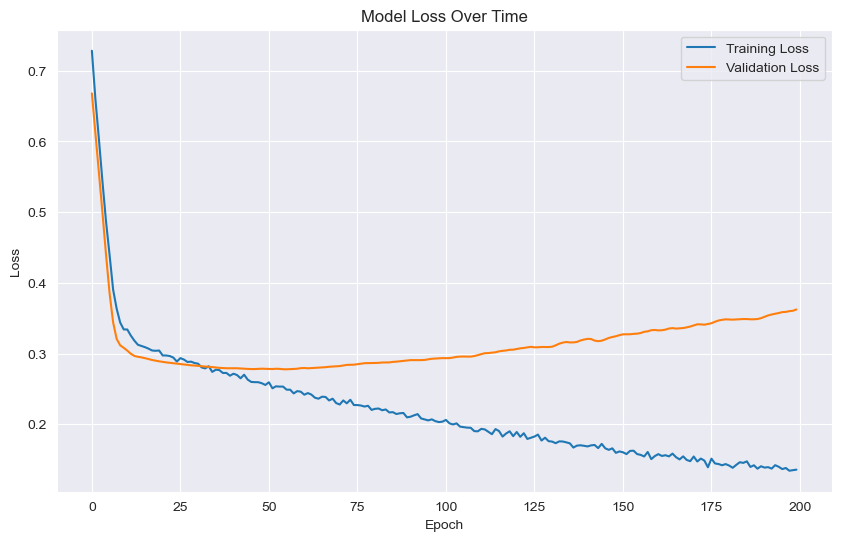

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os


# First, let's prepare our data
# Get feature columns (excluding the Race_ columns)
race_columns = [col for col in train_df.columns if col.startswith('Race_')]
feature_columns = [col for col in train_df.columns if not col.startswith('Race_')]

# Handle missing values in Age column
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)

# Prepare X and y
X = train_df[feature_columns].values
y = train_df[race_columns].values

# Initialize scaler
scaler = StandardScaler()

def create_model(input_dim, l2_lambda=0.0001):
    initial_learning_rate = 0.001
    decay_steps = 1000
    decay_rate = 0.9
    learning_rate_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )
    
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim,
              kernel_regularizer=l2(l2_lambda),
              bias_regularizer=l2(l2_lambda)),
        Dropout(0.2),
        Dense(64, activation='relu',
              kernel_regularizer=l2(l2_lambda),
              bias_regularizer=l2(l2_lambda)),
        Dropout(0.2),
        Dense(64, activation='relu',
              kernel_regularizer=l2(l2_lambda),
              bias_regularizer=l2(l2_lambda)),
        Dropout(0.2),
        Dense(len(race_columns), activation='softmax',
              kernel_regularizer=l2(l2_lambda),
              bias_regularizer=l2(l2_lambda))
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# [Rest of the code remains exactly the same]
def plot_confusion_matrices(y_true, y_pred, class_names):
    """Plot confusion matrices for each class"""
    fig, axes = plt.subplots(2, (len(class_names) + 1) // 2, figsize=(15, 8))
    axes = axes.ravel()
    
    for idx, class_name in enumerate(class_names):
        cm = confusion_matrix(y_true[:, idx], (y_pred[:, idx] > 0.5).astype(int))
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
        axes[idx].set_title(f'Confusion Matrix - {class_name}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    plt.tight_layout()
    return fig

def calculate_metrics(y_true, y_pred_proba):
    """Calculate comprehensive metrics for multi-label classification"""
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    metrics = {
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'precision_micro': precision_score(y_true, y_pred, average='micro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'recall_micro': recall_score(y_true, y_pred, average='micro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_micro': f1_score(y_true, y_pred, average='micro'),
        'roc_auc': roc_auc_score(y_true, y_pred_proba, average='macro'),
        'accuracy': (y_true == y_pred).all(axis=1).mean()
    }
    
    # Per-class metrics
    class_metrics = {
        'precision_per_class': precision_score(y_true, y_pred, average=None),
        'recall_per_class': recall_score(y_true, y_pred, average=None),
        'f1_per_class': f1_score(y_true, y_pred, average=None),
        'roc_auc_per_class': roc_auc_score(y_true, y_pred_proba, average=None)
    }
    
    return metrics, class_metrics

# Perform 10-fold cross validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
all_metrics = []
all_class_metrics = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/10")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train model
    model = create_model(X_train.shape[1])
    
    # Define callbacks    
    model_checkpoint = ModelCheckpoint(
        filepath=f'model_checkpoints/model_fold_{fold+1}.keras',  # Changed from .h5 to .keras
        monitor='val_accuracy',
        save_best_only=True,     # Only save when the monitored metric is improved
        mode='max',              # We want to minimize the validation loss
        verbose=1
    )
    
    # Train the model with callbacks
    history = model.fit(
        X_train_scaled, y_train,
        epochs=200,              # Maximum number of epochs
        batch_size=128,
        validation_data=(X_test_scaled, y_test),
        callbacks=[model_checkpoint],
        verbose=2
    )
    
    # Load the best model for this fold
    best_model = load_model(f'model_checkpoints/model_fold_{fold+1}.keras')
    
    # Get predictions using the best model
    y_pred_train = best_model.predict(X_train_scaled)
    y_pred_test = best_model.predict(X_test_scaled)
    
    # Calculate metrics
    train_metrics, train_class_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics, test_class_metrics = calculate_metrics(y_test, y_pred_test)
    
    
    # Store metrics
    all_metrics.append({
        'fold': fold + 1,
        'train': train_metrics,
        'test': test_metrics
    })
    
    all_class_metrics.append({
        'fold': fold + 1,
        'train': train_class_metrics,
        'test': test_class_metrics
    })
    
    # Print current fold metrics
    print("\nTrain Metrics:")
    for metric_name, value in train_metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    print("\nTest Metrics:")
    for metric_name, value in test_metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # # Plot confusion matrices for this fold
    # plot_confusion_matrices(y_test, y_pred_test, race_columns)
    # plt.show()
    # 
    # # Plot learning curves
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    # plt.axvline(x=np.argmin(history.history['val_loss']), color='r', linestyle='--', 
    #             label='Best Model')
    # plt.title('Model Loss Over Time')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # 
    # plt.subplot(1, 2, 2)
    # plt.plot(history.history['accuracy'], label='Training Accuracy')
    # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    # plt.axvline(x=np.argmin(history.history['val_loss']), color='r', linestyle='--', 
    #             label='Best Model')
    # plt.title('Model Accuracy Over Time')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # 
    # plt.tight_layout()
    # plt.show()

# Calculate and print final average results
print("\nFinal Average Results:")
print("\nOverall Metrics:")
for metric_name in all_metrics[0]['test'].keys():
    test_values = [fold['test'][metric_name] for fold in all_metrics]
    mean_value = np.mean(test_values)
    std_value = np.std(test_values)
    print(f"{metric_name}: {mean_value:.4f} ± {std_value:.4f}")

print("\nPer-Class Metrics:")
for class_idx, class_name in enumerate(race_columns):
    print(f"\n{class_name}:")
    for metric_name in ['precision_per_class', 'recall_per_class', 'f1_per_class', 'roc_auc_per_class']:
        test_values = [fold['test'][metric_name][class_idx] for fold in all_class_metrics]
        mean_value = np.mean(test_values)
        std_value = np.std(test_values)
        print(f"{metric_name}: {mean_value:.4f} ± {std_value:.4f}")

# Plot learning curves from the last fold
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\mihai\AppData\Local\Temp\ipykernel_21064\191246884.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Test Set Results:

Overall Metrics:
precision_macro: 0.1662
precision_micro: 0.2742
recall_macro: 0.0822
recall_micro: 0.0580
f1_macro: 0.0752
f1_micro: 0.0958
roc_auc: 0.6971
accuracy: 0.0580

Per-Class Metrics:

Race_Bengal:
precision_per_class: 0.0000
recall_per_class: 0.0000
f1_per_class: 0.0000
roc_auc_per_class: 0.6674

Race_Birman:
precision_per_class: 0.5000
recall_per_class: 0.0526
f1_per_class: 0.0952
roc_auc_per_class: 0.7007

Race_BritishShorthair:
precision_per_class: 0.0000
recall_per_class: 0.0000
f1_per_class: 0.0000
roc_auc_per_class: 0.7489

Race_Chartreux:
precision_per_class: 0.0000
recall_per_class: 0.0000
f1_per_class: 0.0000
roc_auc_per_class: 0.6207

Race_European:
precision_per_class: 0.5000
recall_per_class: 0.0686
f1_per_class: 0.1207
roc_auc_per_class: 0.6079

Race_MaineCoon:
precision_per_class: 0.5000
recall_per_class: 0.0500
f1_per_class: 

C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1500x800 with 0 Axes>

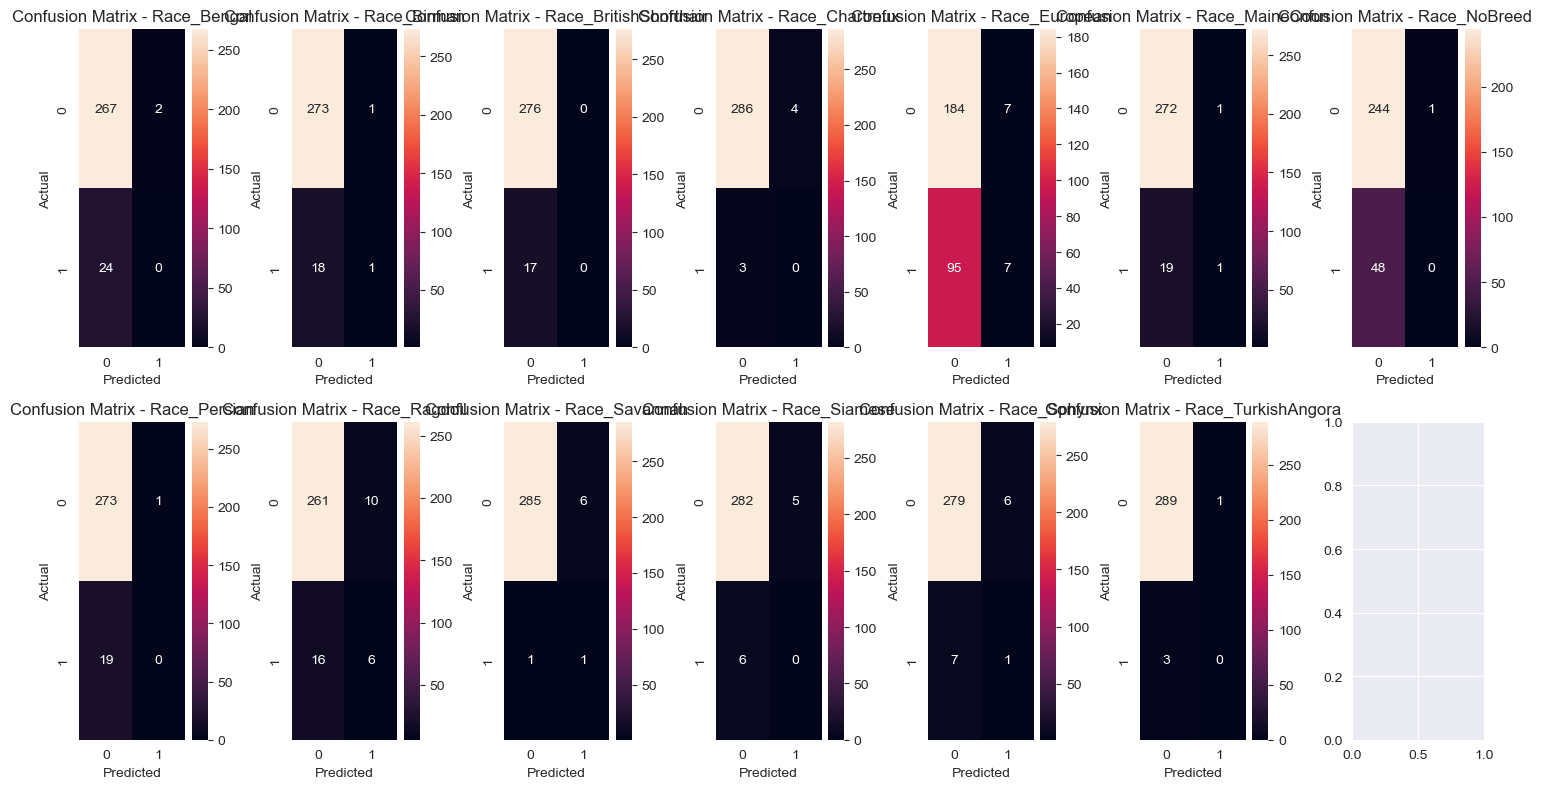

In [38]:
# Prepare test data
# Handle missing values in Age column
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)

# Prepare X_test using the same feature columns as training
X_test = test_df[feature_columns].values
y_test = test_df[race_columns].values

# Scale the features using the same scaler used in training
X_test_scaled = scaler.transform(X_test)

# Since we trained multiple models during cross-validation,
# we can either use a specific fold's model or average predictions from all models
predictions = []

# Load and get predictions from all models
for fold in range(3):
    model_path = f'model_checkpoints/model_fold_{fold+1}.keras'
    if os.path.exists(model_path):
        model = load_model(model_path)
        fold_predictions = model.predict(X_test_scaled)
        predictions.append(fold_predictions)

# Average predictions from all models
y_pred_proba = np.mean(predictions, axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate and print metrics
metrics, class_metrics = calculate_metrics(y_test, y_pred_proba)

print("\nTest Set Results:")
print("\nOverall Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

print("\nPer-Class Metrics:")
for class_idx, class_name in enumerate(race_columns):
    print(f"\n{class_name}:")
    for metric_name, values in class_metrics.items():
        print(f"{metric_name}: {values[class_idx]:.4f}")

# Plot confusion matrices for test set
plt.figure(figsize=(15, 8))
plot_confusion_matrices(y_test, y_pred_proba, race_columns)
plt.show()